# **Convolutional Neural Network - CNN**

## Objectives

* To classify the image set
* To test the performance of the classification using resizing vs resizing + padding

## Inputs

* CSVs outputted from ETL for resizing and resizing + padding

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* If you have any additional comments that don't fit in the previous bullets, please state them here. 



---

## Import Libraries

In [1]:
import numpy as np
import pandas as pd
import os
import base64
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, RandomFlip, RandomRotation, RandomZoom
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project\\jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
if os.path.basename(current_dir).lower() == "jupyter_notebooks":
    os.chdir(os.path.dirname(current_dir))
    print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'c:\\Users\\Eddie\\Documents\\CodeInstitute Workspace\\Capstone Project'

---

# Load CSV files

In [5]:
df_resize = pd.read_csv("./Data/Processed/df_resized.csv")
df_resize_padding = pd.read_csv("./Data/Processed/df_resized_padded.csv")

# Display the first few rows of each DataFrame
df_resize.head()
df_resize_padding.head()

,subfolder,luminance,contrast,image_path,grey_image_path
0,anger,202.218752,42.869499,./Data/Processed/Resized+Padded\image_0.png,./Data/Processed/Resized+Padded\grey_image_0.png
1,anger,134.196622,101.303135,./Data/Processed/Resized+Padded\image_1.png,./Data/Processed/Resized+Padded\grey_image_1.png
2,anger,109.144209,51.433215,./Data/Processed/Resized+Padded\image_2.png,./Data/Processed/Resized+Padded\grey_image_2.png
3,anger,140.261702,89.338355,./Data/Processed/Resized+Padded\image_3.png,./Data/Processed/Resized+Padded\grey_image_3.png
4,anger,143.852701,81.434234,./Data/Processed/Resized+Padded\image_4.png,./Data/Processed/Resized+Padded\grey_image_4.png


In [6]:
'''
#no longer using base64 encoding to store images in dataframes, instead storing file paths

#convert back to numpy arrays
def base64_to_cv2_array(b64_string):
    # Decode base64 → bytes
    img_bytes = base64.b64decode(b64_string)

    # Convert bytes → 1D uint8 array (image buffer)
    img_array = np.frombuffer(img_bytes, dtype=np.uint8)

    return cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)

df_resize['image'] = df_resize['image'].apply(lambda x: base64_to_cv2_array(x))
df_resize['grey_image'] = df_resize['grey_image'].apply(lambda x: base64_to_cv2_array(x))

df_resize_padding['image'] = df_resize_padding['image'].apply(lambda x: base64_to_cv2_array(x))
df_resize_padding['grey_image'] = df_resize_padding['grey_image'].apply(lambda x: base64_to_cv2_array(x))
'''

"\n#no longer using base64 encoding to store images in dataframes, instead storing file paths\n\n#convert back to numpy arrays\ndef base64_to_cv2_array(b64_string):\n    # Decode base64 → bytes\n    img_bytes = base64.b64decode(b64_string)\n\n    # Convert bytes → 1D uint8 array (image buffer)\n    img_array = np.frombuffer(img_bytes, dtype=np.uint8)\n\n    return cv2.imdecode(img_array, cv2.IMREAD_UNCHANGED)\n\ndf_resize['image'] = df_resize['image'].apply(lambda x: base64_to_cv2_array(x))\ndf_resize['grey_image'] = df_resize['grey_image'].apply(lambda x: base64_to_cv2_array(x))\n\ndf_resize_padding['image'] = df_resize_padding['image'].apply(lambda x: base64_to_cv2_array(x))\ndf_resize_padding['grey_image'] = df_resize_padding['grey_image'].apply(lambda x: base64_to_cv2_array(x))\n"

---

# CNN

Encode labels and split data into training, validation, and testing

In [7]:
#encode labels
encoder = LabelEncoder()
df_resize['encoded_labels'] = encoder.fit_transform(df_resize['subfolder'])
df_resize_padding['encoded_labels'] = encoder.fit_transform(df_resize_padding['subfolder'])

#split data into training, validation, and testing
train_df_resize, temp_df_resize = train_test_split(
    df_resize, test_size=0.4, random_state=3, stratify=df_resize['encoded_labels']
)
val_df_resize, test_df_resize = train_test_split(
    temp_df_resize, test_size=0.65, random_state=3, stratify=temp_df_resize['encoded_labels']
)

In [8]:
test_df_resize['encoded_labels'].value_counts()

encoded_labels
3    60
5    58
0    56
1    52
4    44
2    42
Name: count, dtype: int64

Colour images - resized

In [9]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),        # randomly flip left/right
    RandomRotation(0.1),             # rotate up to ±10%
    RandomZoom(0.1),                 # zoom in/out up to ±10%
])

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

'''
stacked_images = np.stack(train_df_resize['image'].values).astype('float16')/255.0
stacked_labels = np.stack(train_df_resize['encoded_labels'].values)
stacked_val_images = np.stack(val_df_resize['image'].values).astype('float16')/255.0
stacked_val_labels = np.stack(val_df_resize['encoded_labels'].values)
stacked_test_images = np.stack(test_df_resize['image'].values).astype('float16')/255.0
stacked_test_labels = np.stack(test_df_resize['encoded_labels'].values)
'''

import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_and_preprocess(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)          # dtype uint8 [0..255]
    img = tf.cast(img, tf.float16) / 255.0              # normalize + convert per batch
    if augment:
        img = data_augmentation(img)
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df_resize["image_path"], train_df_resize["encoded_labels"]))
train_ds = train_ds.map(lambda x, y: load_and_preprocess(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_df_resize["image_path"], val_df_resize["encoded_labels"]))
val_ds = val_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_df_resize["image_path"], test_df_resize["encoded_labels"]))
test_ds = test_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

#model.fit(stacked_images, stacked_labels, epochs=5, validation_data=(stacked_val_images, stacked_val_labels))

#test_loss, test_accuracy = model.evaluate(stacked_test_images, stacked_test_labels)

c:\Users\Eddie\Documents\CodeInstitute Workspace\Capstone Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
def inspect_arr(a, name):
    import numpy as np
    a = np.asarray(a)
    print(name, "dtype", a.dtype, "min", a.min(), "max", a.max(), "shape", a.shape)

# If using tf.data: fetch one batch and inspect
for x,y in train_ds.take(1):
    print("train batch", x.dtype, x.numpy().min(), x.numpy().max())

train batch <dtype: 'float32'> 0.0 1.0


In [11]:
model.fit(train_ds, epochs=50, validation_data=(val_ds))

test_loss, test_accuracy = model.evaluate(test_ds)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 631ms/step - accuracy: 0.1694 - loss: 3.6993 - val_accuracy: 0.1429 - val_loss: 1.7882
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 599ms/step - accuracy: 0.2042 - loss: 1.7550 - val_accuracy: 0.2738 - val_loss: 1.7305
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 592ms/step - accuracy: 0.2778 - loss: 1.7323 - val_accuracy: 0.2560 - val_loss: 1.6902
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 600ms/step - accuracy: 0.3097 - loss: 1.7341 - val_accuracy: 0.3333 - val_loss: 1.6733
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 693ms/step - accuracy: 0.3292 - loss: 1.6780 - val_accuracy: 0.3571 - val_loss: 1.6687
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 698ms/step - accuracy: 0.3292 - loss: 1.6429 - val_accuracy: 0.3750 - val_loss: 1.6815
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 627ms/step - accuracy: 0.3861 - loss: 1.6263 - val_accuracy: 0.3333 - val_loss: 1.6551
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 661ms/step - accuracy: 0.3667 - loss: 1.5965 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 229ms/step


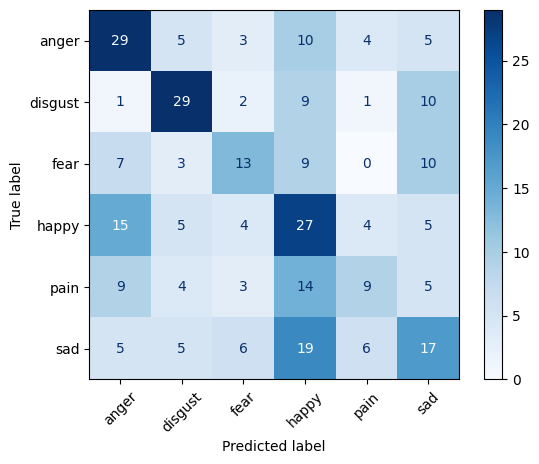

In [12]:
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.concatenate([y for x, y in test_ds], axis=0)

cm = confusion_matrix(y_true, y_pred)
class_names = encoder.classes_
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)

Colour images - resized + padded

In [13]:
#same process is repeated for resized + padded images

model_Padded = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model_Padded.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_padded_ds = tf.data.Dataset.from_tensor_slices((train_df_resize["image_path"], train_df_resize["encoded_labels"]))
train_padded_ds = train_padded_ds.map(lambda x, y: load_and_preprocess(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
train_padded_ds = train_padded_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_padded_ds = tf.data.Dataset.from_tensor_slices((val_df_resize["image_path"], val_df_resize["encoded_labels"]))
val_padded_ds = val_padded_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_padded_ds = val_padded_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_padded_ds = tf.data.Dataset.from_tensor_slices((test_df_resize["image_path"], test_df_resize["encoded_labels"]))
test_padded_ds = test_padded_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_padded_ds = test_padded_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

c:\Users\Eddie\Documents\CodeInstitute Workspace\Capstone Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
model_Padded.fit(train_padded_ds, epochs=50, validation_data=(val_padded_ds))

test_loss, test_accuracy = model_Padded.evaluate(test_padded_ds)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 800ms/step - accuracy: 0.1736 - loss: 2.7693 - val_accuracy: 0.2202 - val_loss: 1.7854
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 728ms/step - accuracy: 0.1958 - loss: 1.7782 - val_accuracy: 0.2024 - val_loss: 1.7610
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 802ms/step - accuracy: 0.2306 - loss: 1.7525 - val_accuracy: 0.2024 - val_loss: 1.7613
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 20s 766ms/step - accuracy: 0.2597 - loss: 1.7277 - val_accuracy: 0.2321 - val_loss: 1.7505
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 17s 742ms/step - accuracy: 0.2986 - loss: 1.7064 - val_accuracy: 0.2976 - val_loss: 1.7134
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 793ms/step - accuracy: 0.3278 - loss: 1.6658 - val_accuracy: 0.3333 - val_loss: 1.6426
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 21s 901ms/step - accuracy: 0.3639 - loss: 1.6213 - val_accuracy: 0.3036 - val_loss: 1.6495
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 18s 751ms/step - accuracy: 0.3472 - loss: 1.6070 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step


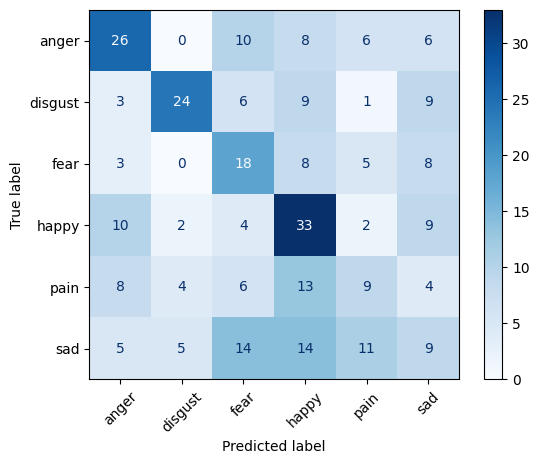

In [15]:
y_pred_probs_padded = model_Padded.predict(test_padded_ds)
y_pred_padded = np.argmax(y_pred_probs_padded, axis=1)
y_true_padded = np.concatenate([y for x, y in test_padded_ds], axis=0)

cm = confusion_matrix(y_true, y_pred_padded)
class_names = encoder.classes_
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)

Greyscale images - resized

In [16]:
#same process is repeated for greyscale resized images

model_Greyscale = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224, 224, 1)),
    MaxPooling2D((2,2)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(6, activation='softmax')
])

model_Greyscale.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

def load_and_preprocess_grey(path, label, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=1)          # dtype uint8 [0..255]
    img = tf.cast(img, tf.float16) / 255.0              # normalize + convert per batch
    if augment:
        img = data_augmentation(img)
    return img, label


train_grey_ds = tf.data.Dataset.from_tensor_slices((train_df_resize["grey_image_path"], train_df_resize["encoded_labels"]))
train_grey_ds = train_grey_ds.map(lambda x, y: load_and_preprocess_grey(x, y, augment=True), num_parallel_calls=tf.data.AUTOTUNE)
train_grey_ds = train_grey_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_grey_ds = tf.data.Dataset.from_tensor_slices((val_df_resize["grey_image_path"], val_df_resize["encoded_labels"]))
val_grey_ds = val_grey_ds.map(load_and_preprocess_grey, num_parallel_calls=tf.data.AUTOTUNE)
val_grey_ds = val_grey_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_grey_ds = tf.data.Dataset.from_tensor_slices((test_df_resize["grey_image_path"], test_df_resize["encoded_labels"]))
test_grey_ds = test_grey_ds.map(load_and_preprocess_grey, num_parallel_calls=tf.data.AUTOTUNE)
test_grey_ds = test_grey_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

c:\Users\Eddie\Documents\CodeInstitute Workspace\Capstone Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model_Greyscale.fit(train_grey_ds, epochs=50, validation_data=(val_grey_ds))

test_loss, test_accuracy = model_Greyscale.evaluate(test_grey_ds)

Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 741ms/step - accuracy: 0.1778 - loss: 2.5092 - val_accuracy: 0.1429 - val_loss: 1.7664
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 672ms/step - accuracy: 0.2264 - loss: 1.7719 - val_accuracy: 0.2857 - val_loss: 1.7666
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 658ms/step - accuracy: 0.2333 - loss: 1.7649 - val_accuracy: 0.2917 - val_loss: 1.7284
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 705ms/step - accuracy: 0.2931 - loss: 1.7557 - val_accuracy: 0.2738 - val_loss: 1.7130
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 19s 645ms/step - accuracy: 0.2917 - loss: 1.7160 - val_accuracy: 0.3333 - val_loss: 1.6903
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 674ms/step - accuracy: 0.2944 - loss: 1.7048 - val_accuracy: 0.3214 - val_loss: 1.6840
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 15s 668ms/step - accuracy: 0.3278 - loss: 1.6862 - val_accuracy: 0.3631 - val_loss: 1.6453
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 14s 604ms/step - accuracy: 0.3569 - loss: 1.6461 - val_accu

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step


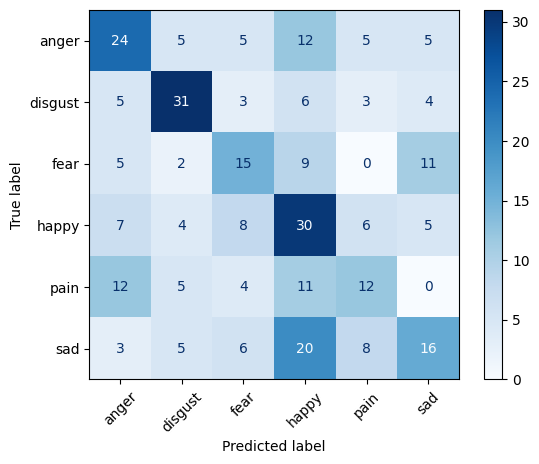

In [18]:
y_pred_probs_grey = model_Greyscale.predict(test_grey_ds)
y_pred_grey = np.argmax(y_pred_probs_grey, axis=1)
y_true_grey = np.concatenate([y for x, y in test_grey_ds], axis=0)

cm = confusion_matrix(y_true_grey, y_pred_grey)
class_names = encoder.classes_
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(cmap='Blues', xticks_rotation=45)

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In cases where you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.